# Research Computing for the Earth Sciences - Final Project
## Mercury in soils and atmospheric deposition in the United States
### Jennifer Angel-Amaya


## Project description

The [Mercury cycle](https://en.wikipedia.org/wiki/Mercury_cycle) is a biogeochemical cycle influenced by natural and anthropogenic processes that transform mercury through multiple chemical forms and environments.

Mercury emissions to the atmosphere can be primary sources, which release mercury from the lithosphere, or secondary sources, which exchange mercury between surface reservoirs.  Atmospheric mercury deposition is a process through which various forms of mercury are removed from the atmosphere. The dry deposition of mercury mainly includes the direct deposition of Hg(0) and RGM (reactive gaseous mercury), which occurs throughout the year as long as it does not rain heavily. The forms of mercury in wet deposition tend to be soluble and granular Hg(II).

![Hg sourcing_wikipedia](Hg_cycle.jpg)

## Objectives

1. The mercury deposition network- MDN is the only one providing a long-term record of total mercury (Hg) concentration and deposition in precipitation in the United States and Canada. My goal is to describe the distribution and trend of wet deposition from 1996 to 2021.


2. Soils account for the largest global mercury reservoirs. The accumulation and turnover of mercury in soils determine whether they act as an atmospheric source or sink. Here, I present soil mercury from a large soil survey (top 5 cm, ∼4800 sites) across the US. I intend to describe the relationship between Hg content and land cover and estimate non-parental mercury or due to other sources than bedrock weathering (parental mercury).


## References

[1] Connor I Olson et al 2022. Mercury in soils of the conterminous United States: patterns and pools. Environ. Res. Lett. 17 074030 https://doi.org/10.1088/1748-9326/ac79c2

[2] National Atmospheric Deposition Program, 2021. National Atmospheric Deposition Program 2021 Annual Summary. Wisconsin State Laboratory of Hygiene, University of Wisconsin-Madison, WI https://nadp.slh.wisc.edu/networks/mercury-deposition-network/

[3] Prestbo, E. & Gay,D. 2009. Wet deposition of mercury in the U.S. and Canada, 1996–2005: Results and analysis of the NADP mercury deposition network (MDN), Atmospheric Environment, Volume 43, Issue 27, Pages 4223-4233, ISSN 1352-2310, https://doi.org/10.1016/j.atmosenv.2009.05.028.

[4] Smith, D.B., Cannon, W.F., Woodruff, L.G., Solano, Federico, Kilburn, J.E., and Fey, D.L., 2013, Geochemical and mineralogical data for soils of the conterminous United States: U.S. Geological Survey Data Series 801, 19 p.,http://pubs.usgs.gov/ds/801/.

[5] Zhang, H., Li, Y., Luo, Y. et al. Anthropogenic mercury sequestration in different soil types on the southeast coast of China. J Soils Sediments 15, 962–971 (2015). https://doi.org/10.1007/s11368-015-1062-1

# Setup

In [133]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import geopandas
import hvplot.pandas
import matplotlib.colors as colors

%matplotlib inline


# Import the data

## Mercury Deposition

The MDN is the only network providing a longterm record of total mercury (Hg) concentration and deposition in precipitation in the United States and Canada.

The CSV files were downloaded from the Mercury Deposition Network (National Atmospheric Deposition Program) at https://nadp.slh.wisc.edu/networks/mercury-deposition-network/:
- "mdn_a" dataset contains the annual Hg Deposition (HgDep [μg/m^2]), Hg concentration [ng/L] and precipitation (cm) from 1996 to 2021 (only complete data)
- "mdn" dataset contains the site information for the 84 stations from the Mercury Deposition Network accross the US (including Inactive sites).

In [134]:
# Import site information from Mercury Deposition Network
mdn= pd.read_csv('mdn.csv') #Load as Dataframe  Mercury Deposition Network

# Set the Site ID as an index
mdn_i=mdn.set_index("siteId")
#mdn_i

In [135]:
# Import Annual Hg Deposition from Mercury Deposition Network
mdn_a= pd.read_csv('MDN-ALL-A-s.csv') 

# Set the Site ID as an index
mdn_ai=mdn_a.set_index("siteid") 
#mdn_ai

#combine in a single dataset the Annual HgDep data with the site coordinates
mdn_annual=mdn_ai.join(mdn_i, how="outer")
#mdn_annual

#Convert DataFrame to GeoDataFrame
mdn_annual_gdf = geopandas.GeoDataFrame(
    mdn_annual, geometry=geopandas.points_from_xy(mdn_annual.longitude, mdn_annual.latitude))

#Drop the -9 and NaN values in HgDep column from mdn_annual_gdf 
mdn_annual_gdf=mdn_annual_gdf[(mdn_annual_gdf.HgDep!=-9)]
mdn_annual_gdf=mdn_annual_gdf[~np.isnan(mdn_annual_gdf.ppt)] #NaN

## Mercury in soils

Beginning in 2007, the U.S. Geological Survey (USGS) collected soil samples from 4857 sites (1 site per 1,600 square kilometers) across the conterminous United States (CONUS) and analyzed them for 45 elements, including mercury. 

The CSV file was downloaded from the Geochemical and Mineralogical Data for Soils of the Conterminous United States at https://pubs.usgs.gov/ds/801/:
- 'Top 5' dataset contains the geochemical characterization first 5 cm, including Hg [mg/kg] collected during 2007-2011.


In [5]:
# Import Top 5cm Hg content in soils from USGS
Top5= pd.read_csv('Top5_soil.csv') 

# Set the Site ID as an index
Top5_i=Top5.set_index("SiteID") 
Top5_i = Top5_i.rename(columns={'Latitude': 'latitude', 'Longitude':'longitude'})
#Top5_i

#Convert DataFrame to GeoDataFrame
Top5_i_gdf = geopandas.GeoDataFrame(
    Top5_i, geometry=geopandas.points_from_xy(Top5_i.longitude, Top5_i.latitude))

#Replace invalid data
Top5_i_gdf=Top5_i_gdf[Top5_i_gdf.Top5_Hg!='N.S.'] # Drop the N.S.  (no sample available) values
Top5_i_gdf = Top5_i_gdf.replace(['<0.01'], 0.01) # Replace the less than 0.01 for 0.01.

#Convert to numeric
Top5_i_gdf = Top5_i_gdf.apply(pd.to_numeric, errors='ignore', downcast='float')


# 1. Trend in Mercury concentration and wet deposition, 1996-2021

## Figure 1. Mercury concentration and deposition in the US

This figure show the Mercury concentration and deposition across the MDN network. Total mercury concentrations are greatest in the South and Southwest and lowest in the Northeast and along the Pacific Coast. Concentrations in the U.S. Gulf Coast region are consistently high, especially in Florida. Mercury deposition follows VWM concentration for the most part across the MDN network, except in the Southwestern U.S. desert, where precipitation is relatively low. The highest deposition rates in the MDN are observed in the southeastern U.S., especially along the Gulf Coast to Florida. Consistently high concentrations combined with higher annual rainfall amounts in this region result in very high deposition rates.  Since deposition is the product of concentration and precipitation, deposition trend analysis and interpretation can be difficult to discern clearly. 

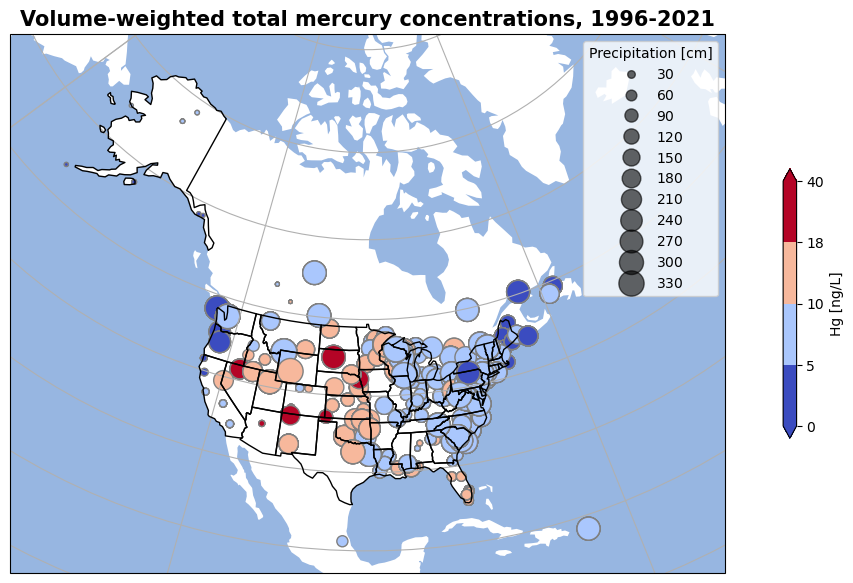

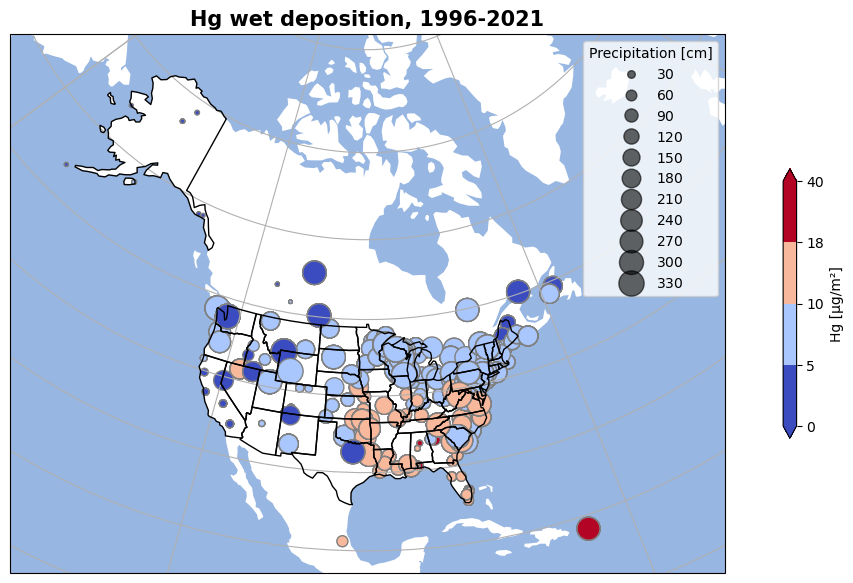

In [142]:
# define map extent
extent = [-140, -50, 12, 78]

# better projection
proj = ccrs.LambertConformal(central_longitude=np.mean(extent[:2]), central_latitude=np.mean(extent[2:]))

# setup map
fig, ax1 = plt.subplots(figsize=(15,7), subplot_kw={'projection': proj})
ax1.set_extent(extent)
ax1.add_feature(cfeature.OCEAN);
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

#array with marker size representing precipitation ranges
s=np.linspace(mdn_annual_gdf.ppt.min(),mdn_annual_gdf.ppt.max(), len(mdn_annual_gdf.ppt))

#plot data
bounds = np.array([0,5,10,18,40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
pcm1=ax1.scatter(mdn_annual_gdf.longitude, mdn_annual_gdf.latitude, transform=ccrs.PlateCarree(), 
                s=s, c=mdn_annual_gdf.HgConc, cmap='coolwarm',norm=norm,edgecolor='gray');

# decorate
ax1.set_title('Volume-weighted total mercury concentrations, 1996-2021',fontsize=15,fontweight='bold')
ax1.gridlines()
fig.colorbar(pcm1, extend='both', orientation='vertical',shrink=0.5, label='Hg [ng/L]')

# produce a legend with sizes acording to precipitation 
handles, labels = pcm1.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax1.legend(handles, labels, loc="upper right", title="Precipitation [cm]")

    # create axes
fig, ax2 = plt.subplots(figsize=(15,7), subplot_kw={'projection': proj})
ax2.set_extent(extent)
ax2.add_feature(cfeature.OCEAN);
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    
    #plot data
bounds = np.array([0,5,10,18,40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)



pcm2=ax2.scatter(mdn_annual_gdf.longitude, mdn_annual_gdf.latitude, transform=ccrs.PlateCarree(), 
                s=s, c=mdn_annual_gdf.HgDep, cmap='coolwarm',norm=norm,edgecolor='gray');
    
    # decorate
ax2.set_title('Hg wet deposition, 1996-2021',fontsize=15,fontweight='bold') 
ax2.gridlines()
fig.colorbar(pcm2, extend='both', orientation='vertical',shrink=0.5, label='Hg [µg/m²]')

# produce a legend with sizes acording to precipitation 
handles, labels = pcm2.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax2.legend(handles, labels, loc="upper right", title="Precipitation [cm]")


## Figure 2. Mercury Deposition Network

This graph shows statistics related to number of sites and wet mercury deposition measured from 1996 to 2021.

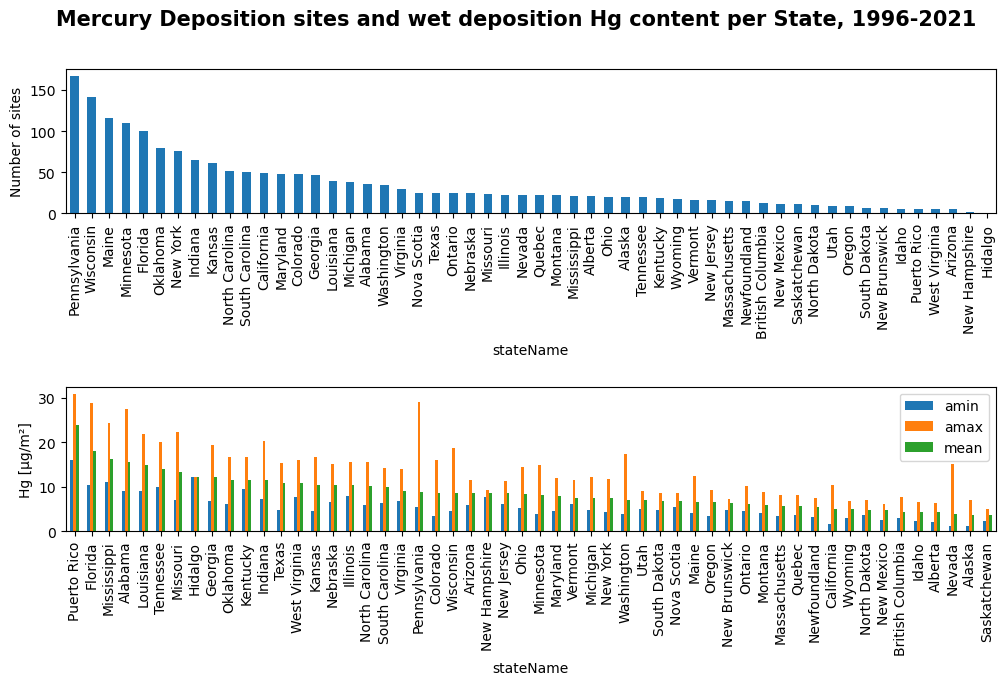

In [143]:
fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(18,10))


mdn_annual_gdf.groupby('stateName').HgDep.count().nlargest(60).plot(kind='bar', figsize=(12,6),ax=ax[0])

# ax[0].set_xticklabels([]);
# ax[0].set_xlabel('');
ax[0].set_ylabel('Number of sites')


gb = mdn_annual_gdf.groupby('stateName')
gb.HgDep.aggregate([np.min, np.max, np.mean]).nlargest(54, 'mean').plot(kind='bar',figsize=(12,6),ax=ax[1]) 
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Hg [µg/m²]')


# gb = Top5_Hg_s.groupby('StateID')
# gb.Top5_Hg.aggregate([np.min, np.max, np.mean]).nlargest(48, 'mean').plot(kind='bar', figsize=(12,6),ax=ax[1]) 


plt.suptitle('Mercury Deposition sites and wet deposition Hg content per State, 1996-2021',fontsize=15,fontweight='bold')
plt.subplots_adjust(hspace = 1.2)
plt.subplots_adjust(wspace = 0.2)


## Figure 3. Annual trend Mercury Concentration and Deposition

In [149]:
gbyr = mdn_annual_gdf.groupby('yr')
#ppt= mdn_annual_gdf.groupby('yr')['ppt'].mean()
gbyr.HgConc.aggregate([np.min, np.max, np.mean]).hvplot(kind='line',width=600, 
                                                        height=400,grid=True, ylabel='Hg [ng/L]', title='Mercury concentration',fontscale=1.6)+\
gbyr.HgDep.aggregate([np.min, np.max, np.mean]).hvplot(kind='line',width=600, 
                                                       height=400,grid=True, ylabel='Hg [µg/m²]', title='Mercury wet deposition',fontscale=1.6) 


:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [yr]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [yr]   (value)

# 2. The relationship between Hg content in soils and land cover and the estimation of non-parental mercury.

#### Hg in soils sampled between 2007 - 2011

## Figure 5. Mercury concentration in the top 5 cm of soil of the conterminous United States

This graph shows the distribution of Hg in soils accross the US. The color scaling is not at regular intervals to reflect the wide distribution. Mercury concentrations in the top 5 cm exceeding 0.25 mg/kg were removed (n=37) to better represent the distribution of the data.

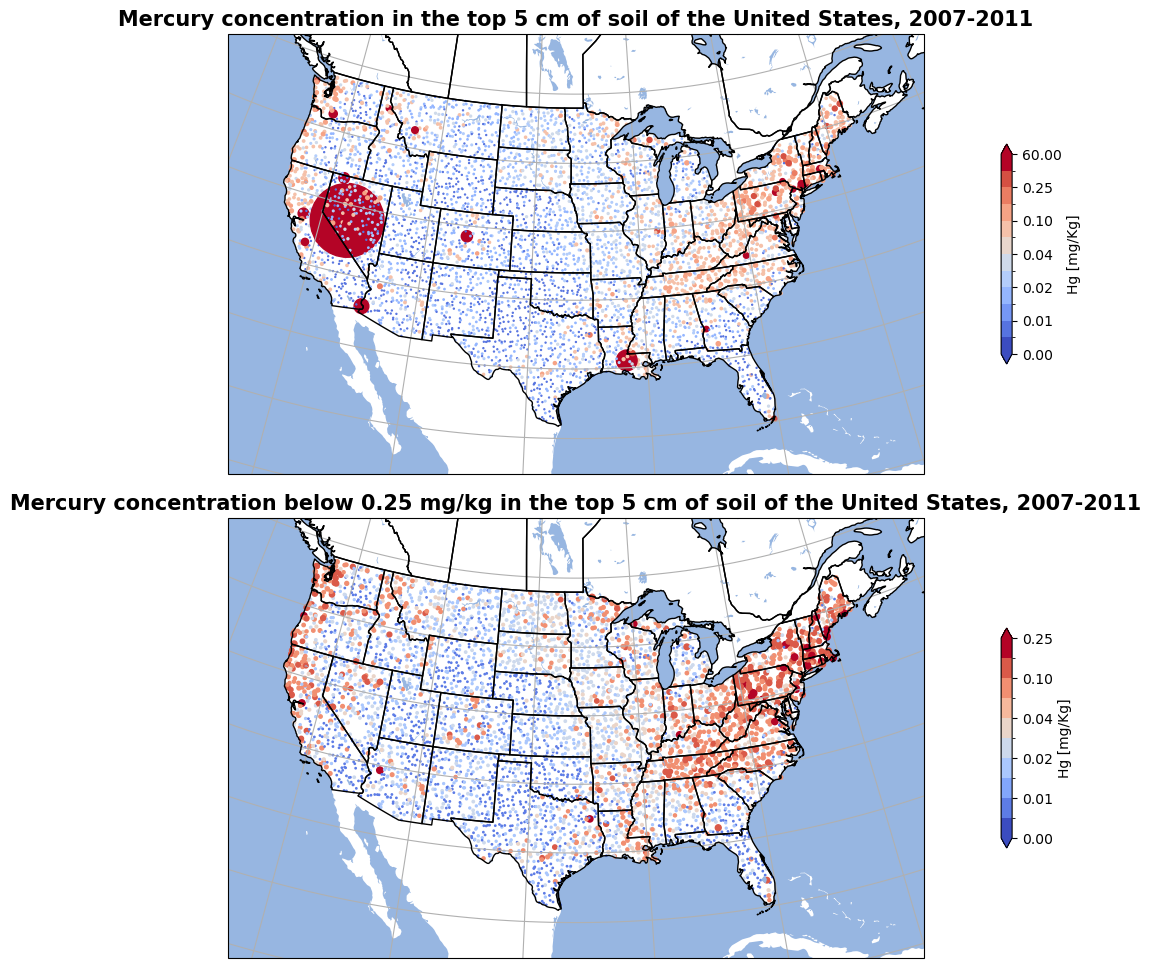

In [151]:
    # define map extent
extent = [-122, -70, 20, 52]

    # better projection
proj = ccrs.LambertConformal(central_longitude=np.mean(extent[:2]), central_latitude=np.mean(extent[2:]))

#setup
fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(20,12),subplot_kw={'projection': proj})
ax[0].set_extent(extent)
ax[0].add_feature(cfeature.OCEAN);
ax[0].add_feature(cfeature.LAKES);
ax[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)

# plot data
bounds = np.array([0,0.008,0.01,0.015,0.02,0.03,0.04,0.05,0.1,0.2,0.25,0.3,60])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
pcm1=ax[0].scatter(Top5_i_gdf.longitude, Top5_i_gdf.latitude, transform=ccrs.PlateCarree(), 
                s=Top5_i_gdf.Top5_Hg*50, c=Top5_i_gdf.Top5_Hg, cmap='coolwarm',norm=norm);
# decorate
ax[0].set_title('Mercury concentration in the top 5 cm of soil of the United States, 2007-2011', fontsize=15,fontweight='bold') 
ax[0].gridlines()
fig.colorbar(pcm1, extend='both', orientation='vertical',shrink=0.5, label='Hg [mg/Kg]')

#  remove the two higher values <0.25 mg/kg
Top5_Hg_s=Top5_i_gdf[(Top5_i_gdf.Top5_Hg<0.25)]  #remove the two higher values 56.40 and 4.43

# decorate
ax[1].set_extent(extent)
ax[1].add_feature(cfeature.OCEAN);
ax[1].add_feature(cfeature.LAKES);
ax[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)

# plot data
bounds = np.array([0,0.008,0.01,0.015,0.02,0.03,0.04,0.05,0.1,0.2,0.25])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
pcm2=ax[1].scatter(Top5_Hg_s.longitude, Top5_Hg_s.latitude, transform=ccrs.PlateCarree(), 
                s=Top5_Hg_s.Top5_Hg*100, c=Top5_Hg_s.Top5_Hg, cmap='coolwarm',norm=norm);

# adjust plot
ax[1].set_title('Mercury concentration below 0.25 mg/kg in the top 5 cm of soil of the United States, 2007-2011',fontsize=15,fontweight='bold') 
ax[1].gridlines()
fig.colorbar(pcm2, extend='both', orientation='vertical',shrink=0.5, label='Hg [mg/Kg]')

plt.subplots_adjust(hspace = 0.1)
plt.subplots_adjust(wspace = 0.2)


## Figure 6. Soil sampling sites and Hg content in the top 5 cm

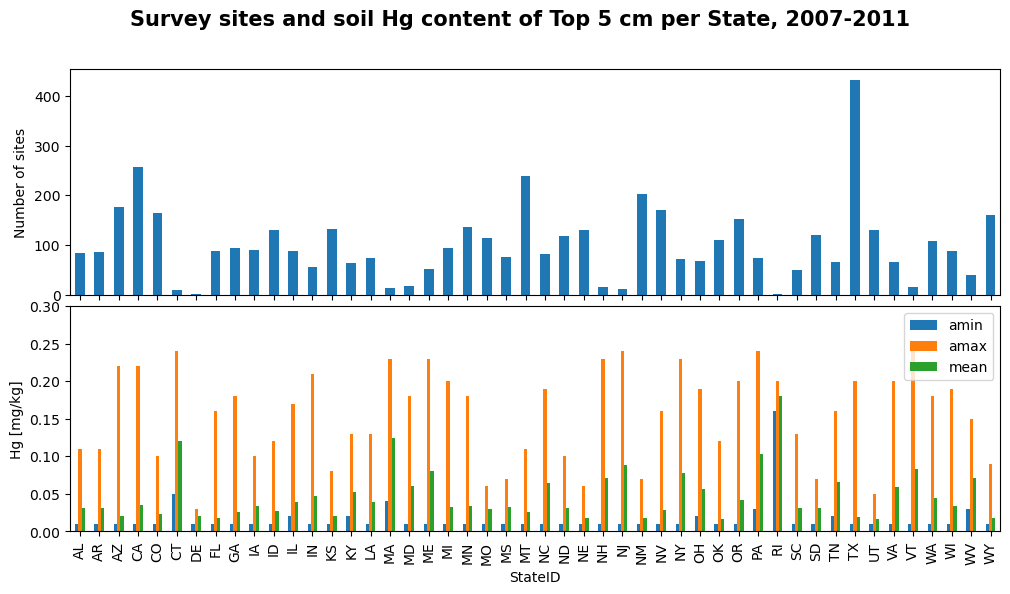

In [146]:
#setup
fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(18,10))

#plot data
Top5_i_gdf.groupby('StateID').Top5_Hg.count().plot(kind='bar', figsize=(12,6),ax=ax[0])
ax[0].set_xticklabels([]);
ax[0].set_xlabel('');
ax[0].set_ylabel('Number of sites')

##plot data
gb = Top5_Hg_s.groupby('StateID')
gb.Top5_Hg.aggregate([np.min, np.max, np.mean]).plot(kind='bar', figsize=(12,6),ax=ax[1],ylim=(0,0.3)) 
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Hg [mg/kg]')

# adjust plot
plt.suptitle('Survey sites and soil Hg content of Top 5 cm per State, 2007-2011',fontsize=15,fontweight='bold')
plt.subplots_adjust(hspace = 0.05)
plt.subplots_adjust(wspace = 0.2)



## Figure 7. Mercury concentration in the top 5 cm of soil for diferent landcover types. 

Landcover type was included as it captures broad physical and ecological characteristics that likely influence soil mercury distribution. Wetland and aquatic landcover
types were excluded from landcover analysis, as they are poorly represented in the soil survey. 


### Figure 7A. Map of select landcover types used in the present study. Source: [1], Data were obtained from the U.S. Geological Survey results 2011 National Land Cover Database (NCLD).
![Hg sourcing](LandCover2.jpg)




### Figure 7B. Hg content in Top 5 cm of soils for diferent landcover types

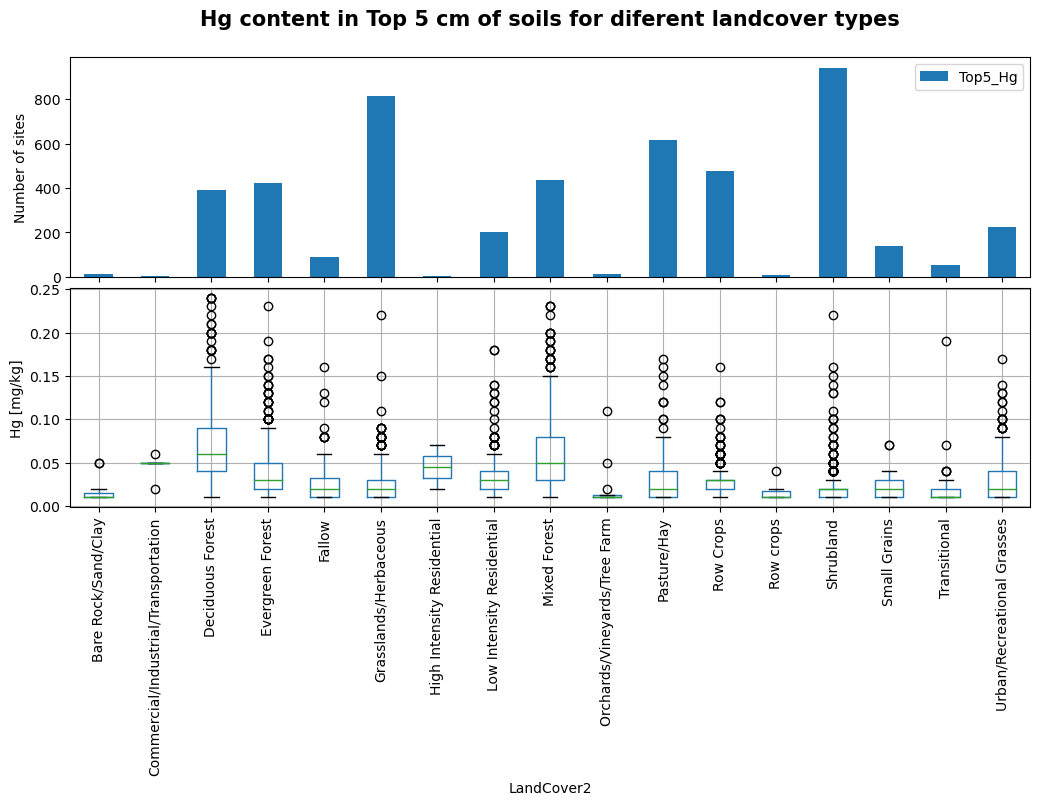

In [166]:
#setup
fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(12,6))

#plot data
Top5_i_gdf.groupby('LandCover2').Top5_Hg.count().plot(kind='bar', rot=90, legend='s', ax=ax[0])
ax[0].set_xticklabels([]);
ax[0].set_xlabel('');
#ax[0].set_title('Number of sites per Land Cover type',fontsize=12)
ax[0].set_ylabel('Number of sites')

#plot data
Top5_Hg_s.boxplot(column=['Top5_Hg'],by='LandCover2',rot=90, figsize=(8,4),ax=ax[1])

ax[1].set_title(' ')
ax[1].set_ylabel('Hg [mg/kg]')

#adjust plot
plt.suptitle('Hg content in Top 5 cm of soils for diferent landcover types' ,fontsize=15,fontweight='bold')
plt.subplots_adjust(hspace = 0.05)
plt.subplots_adjust(wspace = 0.2)



### Soil Hg Sourcing

Bedrock Hg/Ti ratios are commonly used to calculate the amount of parent-derived mercury expected in the soil profile, based on parent
rock weathering alone. This approach assumes that Ti is primarily derived from parent material (regolith) and conserved throughout the soil profile following weathering. Source: [1]

![Hg sourcing](Hg_parental.jpg)

Here I am using the equation presented by [5], where [Hg] endo is the concentration (mg/kg) sourced from mineral weathering in the soil and Ti the measured total Ti concentration (mg/kg) at the top 5 cm . 

![Hg sourcing](Hg_parental_2.jpg)

## Figure 8. Sources of mercury in soils

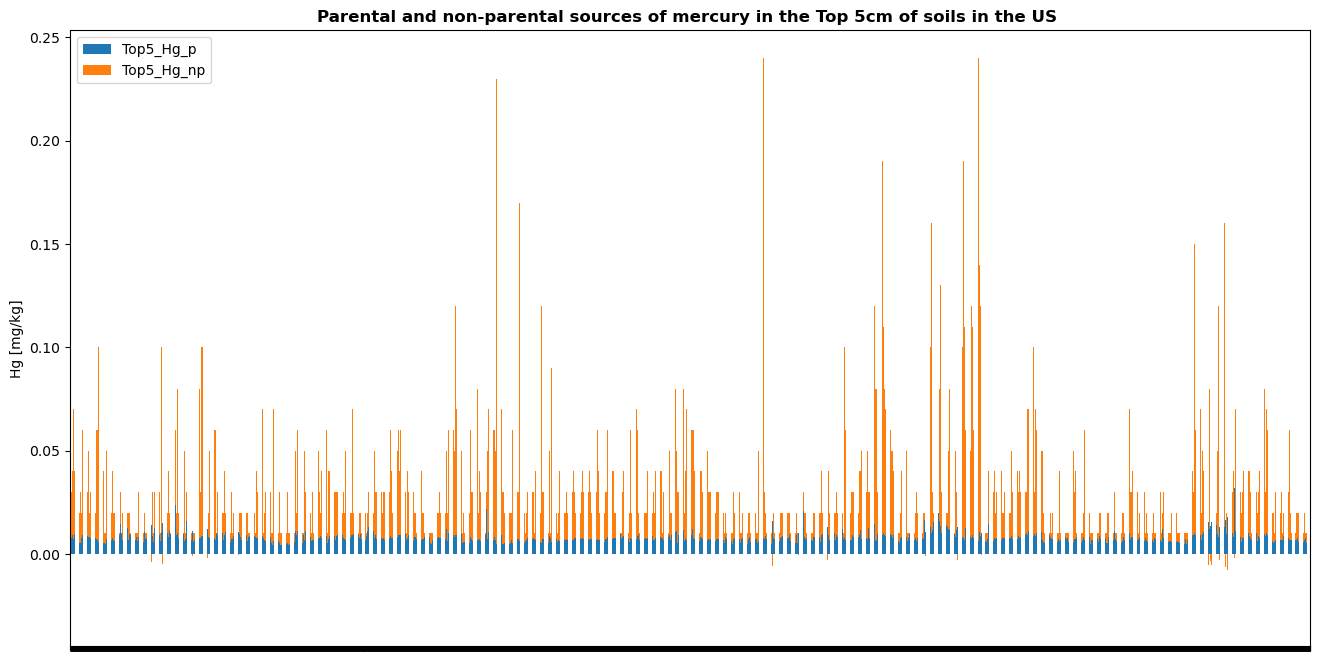

In [148]:
# Calculate parental Hg
Top5_Hg_Ti=Top5_Hg_s[Top5_Hg_s.Top5_Ti!='N.S.']
Top5_Hg_p=0.015*Top5_Hg_Ti.Top5_Ti+0.004

#non-parental Hg
Top5_Hg_np=Top5_Hg_s.Top5_Hg-Top5_Hg_p

#Creating new DataFrame Hg Source
frame = { 'Top5_Hg_p': Top5_Hg_p, 'Top5_Hg_np': Top5_Hg_np }
Hg_source = pd.DataFrame(frame)


ax = Hg_source.plot.bar(stacked=True,figsize=(16,8))
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_title('Parental and non-parental sources of mercury in the Top 5cm of soils in the US ',fontsize=12, fontweight='bold')
ax.set_ylabel('Hg [mg/kg]');

# Conclusions

#### 1.  Trend in Mercury concentration and wet deposition, 1996-2021

The highest deposition rates in the MDN are observed in the southeastern U.S., especially along the Gulf Coast to Florida. Consistently high concentrations combined with higher annual rainfall amounts in this region result in very high deposition rates. 

Any increases in average precipitation could lead to a general decrease in concentration due to dilution of the washout loading. Deposition trends are much more complicated than trends in Hg concentrations, because increasing precipitation over time with constant concentration would lead to increases in deposition, and vise-versa.

Hg concentration and wet deposition are generally decreasing from year to year with peaks during certain years. In 24 years (1997-2021) Hg concentration has decreased 0.7% per year and Hg wet deposition 0.6% per year.  Deposition is the product of concentration and precipitation, deposition trend analysis and interpretation can be difficult to discern clearly. This decreasing Hg concentration could be linked to the closure of medical waste incinerators in 1997 and other mercury emission reductions, but this is difficult to test without accurate trends in emissions, or a more extensive 
monitoring network.


#### 2. The relationship between Hg content in soils and land cover and the estimation of non-parental mercury.¶

This consideration results in a less pronounced enrichment of mercury in carbon-rich landcover types. Mercury areal densities are highest in mixed and deciduous forests, pastures and croplands, and developed land types, while grasslands, shrublands, and barren landcover types are the lowest. However the soil sampling efforts are biased towards mineral soil estimates and away from some soil types (e.g. wetlands are not well represented).

The provenance of mercury in soils was investigated
using bedrock Hg/Ti ratios from [5] and indicate that 62%–95% of soil mercury is from nonparental sources. These sources may include natural and anthropogenic inputs as well as soil translocation, though the current methodology does not allow for further inquiry.

#### 3. The contrasting results between Hg deposition and Hg in the Top 5 cm of soils across the US suggest a complicated source–receptor chemistry and transport fate for mercury.